### **Importing libraries**

In [2]:
!pip install opencv-python matplotlib tensorflow split-folders

In [3]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.2
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
dm-tree                      0.1.8
executing                    2.0.1
flatbuffers                  23.5.26
fonttools                    4.39.2
gast                         0.5.4
google-auth                  2.26.2
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
grpcio                       1.60.0
h5py                         3.10.0
idna                         3.6
ipykernel                    6.28.0
ipython                      8.20.0
jedi                         0.19.

In [4]:
import tensorflow as tf
import os
#from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[]

### **Split data**

Initial dataset consist of 2 classes *('FAKE', 'REAL')*, each class consist of **60 000** images.

The data was split into three folders using below mentioned script.

**85%** - **TRAIN** data, **10%** - **VALIDATION** data, **5%** - **TEST** data

In [11]:
!pip install split-folders

In [22]:
import splitfolders

# splitfolders.ratio("data", # The location of dataset
#                    output="ai_real_dataset", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.85, .10, .05), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

splitfolders.ratio("C:/Users/Marcin/Desktop/ISA_II/GSN/data/",
                   output="C:/Users/Marcin/Desktop/ISA_II/GSN/output/",
                   seed=42,
                   ratio=(.85, .1, .05),
                   group_prefix=None,
                   move=False)

## Load dataset from drive (valid only in COLAB)

In [13]:
#drive.mount('/content/drive')
#!unzip -uq "/content/drive/My Drive/ai_real_dataset.zip" -d "/content"

## Initiate Keras datasets from the uploaded files

In [23]:
base='C:/Users/Marcin/Desktop/ISA_II/GSN/output'
train_dir = os.path.join(base, 'train')
validation_dir = os.path.join(base, 'val')
test_dir = os.path.join(base, 'test')

Define batch size, image size and matrix shape

In [25]:
BATCH_SIZE = 128
IMG_SIZE = (32, 32)
IMG_SHAPE = IMG_SIZE + (3,)

In [26]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 102000 files belonging to 2 classes.


In [27]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 12000 files belonging to 2 classes.


In [28]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6000 files belonging to 2 classes.


## Plot images

['FAKE', 'REAL']


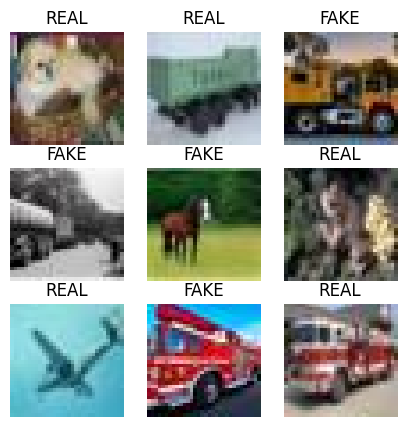

In [29]:
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 797
Number of validation batches: 94
Number of test batches: 47


#### Optimize data loading performance

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Data augmentation**

## Augmentation layers

* **tf.keras.layers.RandomContrast(0.7):** randomly adjusts the contrast of images by a factor of 0.7, introducing variation in image appearance.

* **tf.keras.layers.RandomFlip('horizontal')**: randomly flips images horizontally, creating mirrored versions of the original images.

* **tf.keras.layers.RandomRotation(0.2)**: randomly rotates images by up to 0.2 radians, adding rotation-based diversity to the dataset.

* **tf.keras.layers.RandomZoom(0.3, 0.2)**: randomly zooms in or out on images, with zoom factors ranging from 0.3 to 0.2.

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(0.7),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3, 0.2),
])

## Augmentation visualization

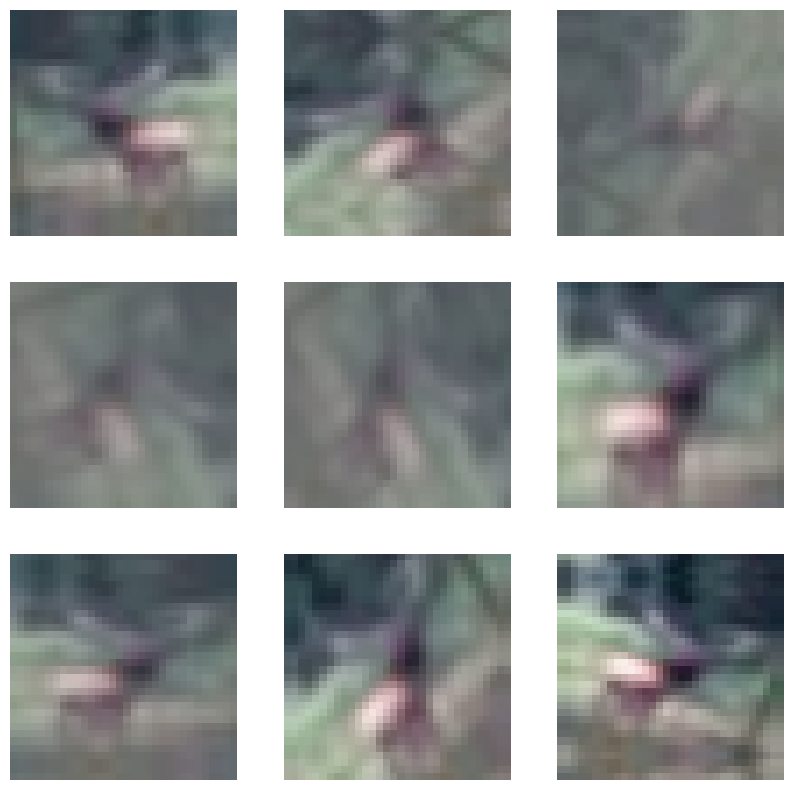

In [33]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## **CNN**

### Import libraries

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from keras.activations import relu
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input

### Build a model

In [90]:
# Define the model
model1 = tf.keras.Sequential()

# Convolutional layers
model1.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model1.add(layers.Flatten())

# Dense layers
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))  # Optional dropout for regularization
model1.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

### Compile the model

In [91]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model summary

In [92]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 64)         

### Data augmentation on train dataset

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(32,32),  # all images will be resized to 32x32
        batch_size=BATCH_SIZE,
        class_mode='binary')

  #tf.keras.layers.RandomContrast(0.7),

Found 102000 images belonging to 2 classes.


### Creating a checkpoint callback for saving weights

In [94]:
checkpoint_path ="cnn/cnn-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

### Loading weights from the latest checkpoint (if it exists)

In [108]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
if(latest==None):
    print("No weights to load")
else:
    model1.load_weights(latest)

cnn\cnn-0029.ckpt


### Training model

In [44]:
#history1 = model1.fit(train_dataset,
history1 = model1.fit(train_generator,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback])

Epoch 1/30


797/797 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7286
Epoch 1: saving model to cnn\cnn-0001.ckpt
797/797 [==============================] - 59s 73ms/step - loss: 0.5625 - accuracy: 0.7286 - val_loss: 0.4342 - val_accuracy: 0.7829
Epoch 2/30
797/797 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8100
Epoch 2: saving model to cnn\cnn-0002.ckpt
797/797 [==============================] - 63s 79ms/step - loss: 0.4233 - accuracy: 0.8100 - val_loss: 0.3753 - val_accuracy: 0.8233
Epoch 3/30
797/797 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8341
Epoch 3: saving model to cnn\cnn-0003.ckpt
797/797 [==============================] - 63s 79ms/step - loss: 0.3819 - accuracy: 0.8341 - val_loss: 0.4004 - val_accuracy: 0.8228
Epoch 4/30
796/797 [============================>.] - ETA: 0s - loss: 0.3554 - accuracy: 0.8490
Epoch 4: saving model to cnn\cnn-0004.ckpt
797/797 [==============================] - 

## **EficientNet**

In [51]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape = IMG_SHAPE)

#### Freezing early layers

In [53]:
#base_model.trainable = False

for layer in base_model.layers[:230]:
		layer.trainable = False

# for layer in base_model.layers[18:]:
# 		layer.trainable = True

#### Summarizing the model

In [54]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, 32, 32, 3)            0         ['input_9[0][0]']             
                                                                                                  
 normalization_8 (Normaliza  (None, 32, 32, 3)            7         ['rescaling_16[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_17 (Rescaling)    (None, 32, 32, 3)            0         ['normalization_8

#### Adding custom layers

In [55]:
inputs = layers.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = preprocess_input(x)
x = base_model(x)
#x = AveragePooling2D(8,8)(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

In [56]:
model2 = Model(inputs, outputs)

#### Compiling the model

In [115]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model2.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy() , metrics=['accuracy'])

#### Summarizing the model

In [58]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                             

### Creating a checkpoint callback for saving weights

In [59]:
checkpoint_path2 ="eff/eff-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,save_weights_only=True,verbose=1)

### Loading weights from the latest checkpoint

In [73]:
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
if(latest2==None):
    print("No weights to load")
else:
    model2.load_weights(latest2)

In [61]:
history2 = model2.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback2])

Epoch 1/30


796/797 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.5634
Epoch 1: saving model to eff\eff-0001.ckpt
797/797 [==============================] - 40s 44ms/step - loss: 1.0410 - accuracy: 0.5633 - val_loss: 0.5787 - val_accuracy: 0.7103
Epoch 2/30
797/797 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.6246
Epoch 2: saving model to eff\eff-0002.ckpt
797/797 [==============================] - 34s 42ms/step - loss: 0.8663 - accuracy: 0.6246 - val_loss: 0.5177 - val_accuracy: 0.7523
Epoch 3/30
796/797 [============================>.] - ETA: 0s - loss: 0.7864 - accuracy: 0.6482
Epoch 3: saving model to eff\eff-0003.ckpt
797/797 [==============================] - 34s 42ms/step - loss: 0.7865 - accuracy: 0.6482 - val_loss: 0.4866 - val_accuracy: 0.7686
Epoch 4/30
797/797 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.6695
Epoch 4: saving model to eff\eff-0004.ckpt
797/797 [==============================] - 34s 42ms/step

## **Training process analysis**

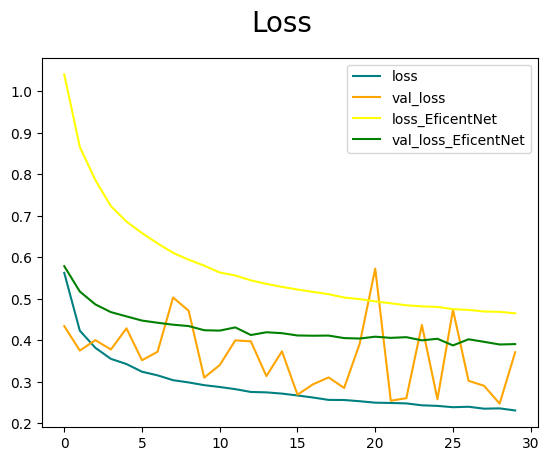

In [62]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history1.history['loss'], color='teal', label='loss')
plt.plot(history1.history['val_loss'], color='orange', label='val_loss')
plt.plot(history2.history['loss'], color='yellow', label='loss_EficentNet')
plt.plot(history2.history['val_loss'], color='green', label='val_loss_EficentNet')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

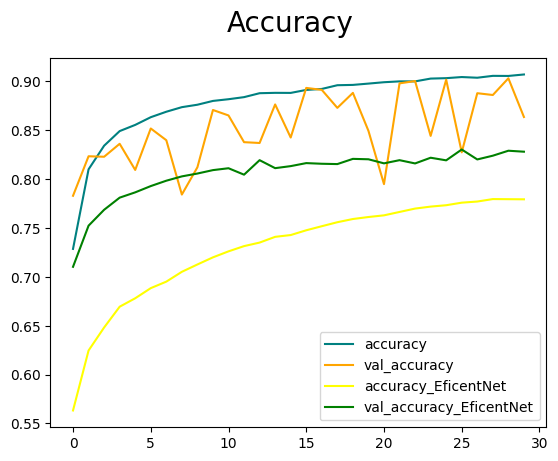

In [63]:
fig = plt.figure()
plt.plot(history1.history['accuracy'], color='teal', label='accuracy')
plt.plot(history1.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(history2.history['accuracy'], color='yellow', label='accuracy_EficentNet')
plt.plot(history2.history['val_accuracy'], color='green', label='val_accuracy_EficentNet')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

## **Testing**

In [109]:
predicted_classes1 = np.array([])
predicted_classes2 = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predicted_classes1 = np.concatenate([predicted_classes1,
                                       np.array([(0 if z[0]<0.5 else 1) for z in model1.predict(x)])])
  predicted_classes2 = np.concatenate([predicted_classes2,
                       np.argmax(model2.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

4/4 [==============================] - 0s 34ms/step


In [101]:
print(labels)

[0. 1. 0. ... 1. 1. 1.]


[[2881  119]
 [ 469 2531]]
              precision    recall  f1-score   support

        FAKE       0.86      0.96      0.91      3000
        REAL       0.96      0.84      0.90      3000

    accuracy                           0.90      6000
   macro avg       0.91      0.90      0.90      6000
weighted avg       0.91      0.90      0.90      6000



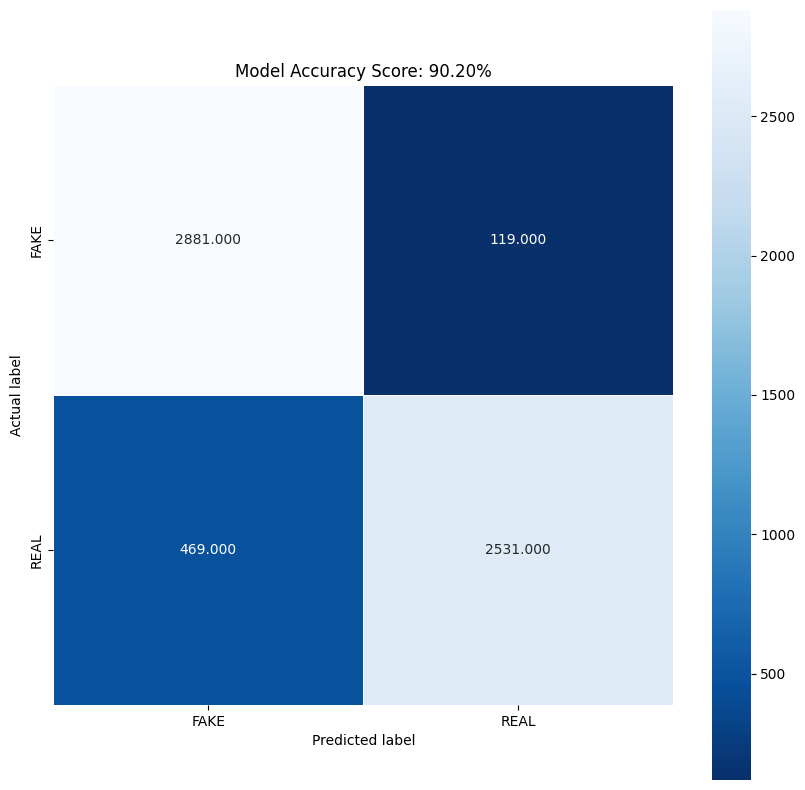

In [116]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model1.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes1)

print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('foo.png')

print(classification_report(labels, predicted_classes1, target_names=class_names))

[[2809  191]
 [ 836 2164]]
              precision    recall  f1-score   support

        FAKE       0.77      0.94      0.85      3000
        REAL       0.92      0.72      0.81      3000

    accuracy                           0.83      6000
   macro avg       0.84      0.83      0.83      6000
weighted avg       0.84      0.83      0.83      6000



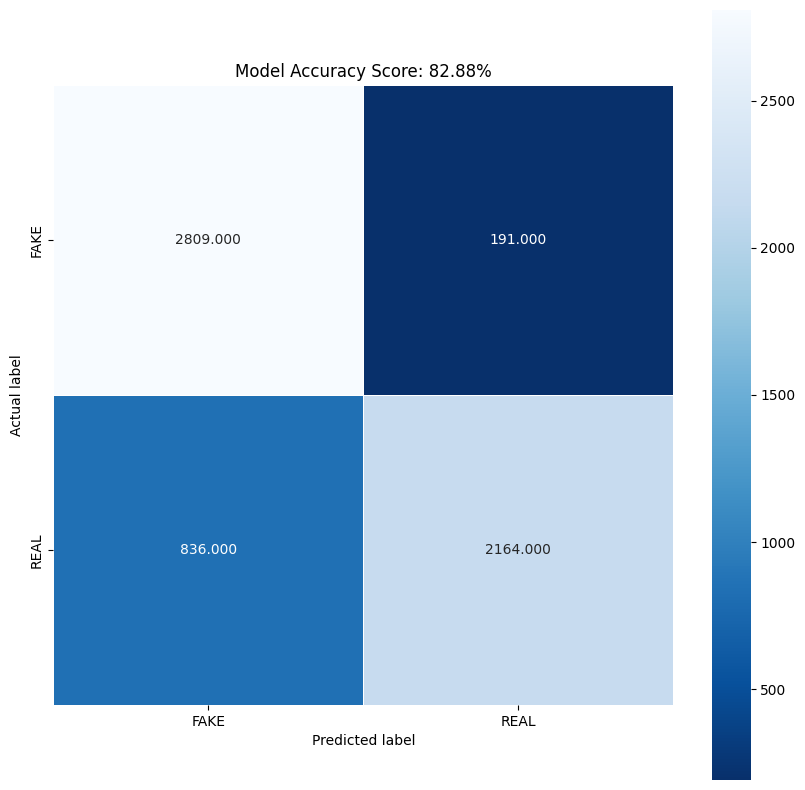

In [120]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model2.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes2)

print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('bar.png')

print(classification_report(labels, predicted_classes2, target_names=class_names))

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Ścieżka do folderu z obrazami wejściowymi
input_folder = '/content/drive/My Drive/testing/real'

# Funkcja do przetwarzania obrazów
def process_image(image_path):
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizacja

    return img_array

# Iteruj przez obrazy wejściowe
for filename in os.listdir(input_folder):
        input_image_path = os.path.join(input_folder, filename)

        # Przetwarzaj obraz za pomocą modelu1
        input_img_array = process_image(input_image_path)
        prediction1 = model1.predict(input_img_array)
        class1 = (0 if model1.predict(x)[0]<0.5 else 1)

        # Przetwarzaj obraz za pomocą modelu2
        input_img_array = process_image(input_image_path)
        prediction2 = model2.predict(input_img_array)
        class2 = np.argmax(prediction2)

        # Twórz wykres z podpisem klas
        plt.figure()
        plt.imshow(image.load_img(input_image_path))
        plt.title(f'Class 1: {class1}, Class 2: {class2}')
        plt.show()
